In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Generate realistic HR data
np.random.seed(42)
dates = pd.date_range('2024-01-01', '2024-03-31', freq='D')
employee_ids = [f'E{str(i).zfill(3)}' for i in range(1, 101)]
departments = ['IT', 'Sales', 'HR', 'Finance', 'Marketing', 'Operations']

# Create sample dataset
data = []
for date in dates:
    if date.weekday() < 5:  # Only weekdays
        for emp_id in employee_ids:
            department = np.random.choice(departments)
            
            # Base work hours with some variation
            base_checkin = datetime.combine(date.date(), datetime.strptime('09:00', '%H:%M').time())
            base_checkout = datetime.combine(date.date(), datetime.strptime('17:00', '%H:%M').time())
            
            # Add realistic variations
            lateness = np.random.exponential(15)  # Lateness in minutes
            early_leave = np.random.exponential(10)  # Early leave in minutes
            
            # 5% chance of being very late (>60 min)
            if np.random.random() < 0.05:
                lateness += 60
            
            # 3% chance of absence
            is_absent = np.random.random() < 0.03
            
            checkin_time = base_checkin + timedelta(minutes=lateness) if not is_absent else None
            checkout_time = base_checkout - timedelta(minutes=early_leave) if not is_absent else None
            
            data.append({
                'employeeId': emp_id,
                'date': date,
                'check_in_time': checkin_time,
                'check_out_time': checkout_time,
                'department': department,
                'is_absent': is_absent
            })

df = pd.DataFrame(data)
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print("\nDepartment Distribution:")
print(df['department'].value_counts())

Dataset Overview:
Shape: (6500, 6)
Date Range: 2024-01-01 00:00:00 to 2024-03-29 00:00:00

Department Distribution:
department
Marketing     1117
Finance       1097
IT            1094
Operations    1074
HR            1068
Sales         1050
Name: count, dtype: int64


In [ ]:
# Data Cleaning Function
def clean_attendance_data(df):
    df_clean = df.copy()
    
    # Remove future dates (if any)
    current_date = pd.Timestamp.now()
    df_clean = df_clean[df_clean['date'] <= current_date]
    
    # Handle missing entries
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=['employeeId', 'date', 'department'])
    
    # Identify anomalies in check-in/check-out times
    if 'check_in_time' in df_clean.columns and 'check_out_time' in df_clean.columns:
        # Remove records where check-out is before check-in
        valid_times = (
            (df_clean['check_in_time'].notna()) & 
            (df_clean['check_out_time'].notna()) &
            (df_clean['check_out_time'] > df_clean['check_in_time'])
        )
        df_clean = df_clean[valid_times | df_clean['is_absent']]
    
    print(f"Cleaning Summary:")
    print(f"Original records: {initial_count}")
    print(f"After cleaning: {len(df_clean)}")
    print(f"Records removed: {initial_count - len(df_clean)}")
    
    return df_clean

df_clean = clean_attendance_data(df)# Data Cleaning Function
def clean_attendance_data(df):
    df_clean = df.copy()
    
    # Remove future dates (if any)
    current_date = pd.Timestamp.now()
    df_clean = df_clean[df_clean['date'] <= current_date]
    
    # Handle missing entries
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=['employeeId', 'date', 'department'])
    
    # Identify anomalies in check-in/check-out times
    if 'check_in_time' in df_clean.columns and 'check_out_time' in df_clean.columns:
        # Remove records where check-out is before check-in
        valid_times = (
            (df_clean['check_in_time'].notna()) & 
            (df_clean['check_out_time'].notna()) &
            (df_clean['check_out_time'] > df_clean['check_in_time'])
        )
        df_clean = df_clean[valid_times | df_clean['is_absent']]
    
    print(f"Cleaning Summary:")
    print(f"Original records: {initial_count}")
    print(f"After cleaning: {len(df_clean)}")
    print(f"Records removed: {initial_count - len(df_clean)}")
    
    return df_clean

df_clean = clean_attendance_data(df)

Cleaning Summary:
Original records: 6500
After cleaning: 6500
Records removed: 0
Cleaning Summary:
Original records: 6500
After cleaning: 6500
Records removed: 0


In [ ]:
def calculate_metrics(df):
    df_metrics = df.copy()
    
    # Calculate lateness minutes (assuming 9:00 AM as official start)
    official_start = datetime.strptime('09:00', '%H:%M').time()
    
    def calculate_lateness(row):
        if pd.isna(row['check_in_time']) or row['is_absent']:
            return 0
        checkin_time = row['check_in_time'].time()
        if checkin_time > official_start:
            lateness_minutes = (datetime.combine(row['date'].date(), checkin_time) - 
                              datetime.combine(row['date'].date(), official_start)).seconds / 60
            return max(0, lateness_minutes)
        return 0
    
    def calculate_hours_worked(row):
        if pd.isna(row['check_in_time']) or pd.isna(row['check_out_time']) or row['is_absent']:
            return 0
        hours = (row['check_out_time'] - row['check_in_time']).seconds / 3600
        return max(0, hours)
    
    df_metrics['lateness_minutes'] = df_metrics.apply(calculate_lateness, axis=1)
    df_metrics['hours_worked'] = df_metrics.apply(calculate_hours_worked, axis=1)
    df_metrics['is_late'] = df_metrics['lateness_minutes'] > 0
    df_metrics['day_of_week'] = df_metrics['date'].dt.day_name()
    df_metrics['month'] = df_metrics['date'].dt.month_name()
    
    return df_metrics

df_metrics = calculate_metrics(df_clean)

print("Metrics Summary:")
print(f"Average lateness: {df_metrics['lateness_minutes'].mean():.1f} minutes")
print(f"Average hours worked: {df_metrics['hours_worked'].mean():.1f} hours")
print(f"Absence rate: {df_metrics['is_absent'].mean()*100:.1f}%")

Metrics Summary:
Average lateness: 17.6 minutes
Average hours worked: 7.3 hours
Absence rate: 3.1%


In [ ]:
# Department Analysis
dept_analysis = df_metrics.groupby('department').agg({
    'employeeId': 'count',
    'is_absent': 'sum',
    'lateness_minutes': 'mean',
    'hours_worked': 'mean',
    'is_late': 'sum'
}).round(2)

dept_analysis['attendance_rate'] = (1 - dept_analysis['is_absent'] / dept_analysis['employeeId']) * 100
dept_analysis['lateness_rate'] = (dept_analysis['is_late'] / dept_analysis['employeeId']) * 100

print("Department-wise Analysis:")
print(dept_analysis[['attendance_rate', 'lateness_minutes', 'hours_worked', 'lateness_rate']])

Department-wise Analysis:
            attendance_rate  lateness_minutes  hours_worked  lateness_rate
department                                                                
Finance           97.265269             17.48          7.33      96.991796
HR                96.816479             18.27          7.29      96.816479
IT                96.252285             17.30          7.25      96.160878
Marketing         96.687556             17.69          7.29      96.687556
Operations        96.927374             18.28          7.29      96.834264
Sales             97.523810             16.81          7.36      97.523810


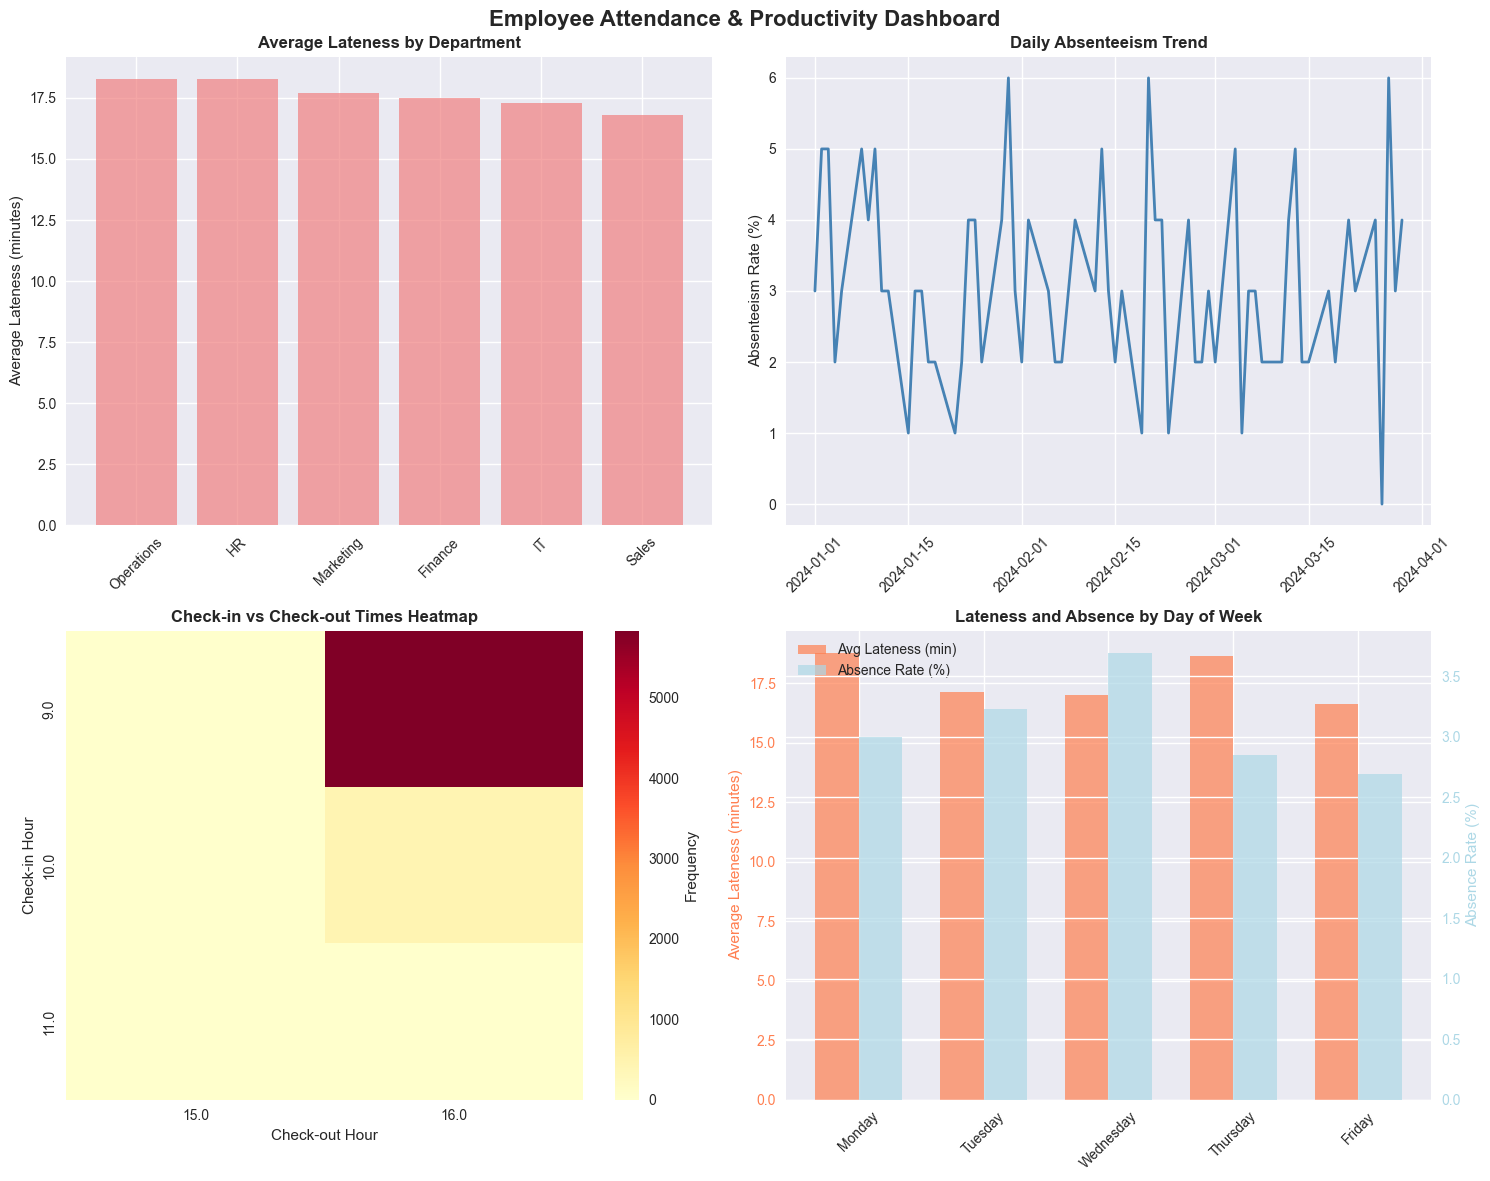

In [ ]:
# Create visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Employee Attendance & Productivity Dashboard', fontsize=16, fontweight='bold')

# 1. Bar chart - Lateness by Department
dept_lateness = df_metrics.groupby('department')['lateness_minutes'].mean().sort_values(ascending=False)
axes[0,0].bar(dept_lateness.index, dept_lateness.values, color='lightcoral', alpha=0.7)
axes[0,0].set_title('Average Lateness by Department', fontweight='bold')
axes[0,0].set_ylabel('Average Lateness (minutes)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Line chart - Absenteeism Trend
daily_absenteeism = df_metrics.groupby('date')['is_absent'].mean() * 100
axes[0,1].plot(daily_absenteeism.index, daily_absenteeism.values, linewidth=2, color='steelblue')
axes[0,1].set_title('Daily Absenteeism Trend', fontweight='bold')
axes[0,1].set_ylabel('Absenteeism Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Heatmap - Arrival/Exit Times
# Extract hour of check-in and check-out
df_metrics['checkin_hour'] = df_metrics['check_in_time'].dt.hour
df_metrics['checkout_hour'] = df_metrics['check_out_time'].dt.hour

# Create pivot for heatmap
heatmap_data = pd.crosstab(df_metrics['checkin_hour'], df_metrics['checkout_hour'])
sns.heatmap(heatmap_data, ax=axes[1,0], cmap='YlOrRd', cbar_kws={'label': 'Frequency'})
axes[1,0].set_title('Check-in vs Check-out Times Heatmap', fontweight='bold')
axes[1,0].set_xlabel('Check-out Hour')
axes[1,0].set_ylabel('Check-in Hour')

# 4. Day-of-week analysis
day_analysis = df_metrics.groupby('day_of_week').agg({
    'lateness_minutes': 'mean',
    'is_absent': 'mean'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

x = range(len(day_analysis.index))
width = 0.35
axes[1,1].bar([i - width/2 for i in x], day_analysis['lateness_minutes'], width, 
              label='Avg Lateness (min)', alpha=0.7, color='coral')
axes[1,1].set_ylabel('Average Lateness (minutes)', color='coral')
axes[1,1].tick_params(axis='y', labelcolor='coral')

ax2 = axes[1,1].twinx()
ax2.bar([i + width/2 for i in x], day_analysis['is_absent'] * 100, width, 
        label='Absence Rate (%)', alpha=0.7, color='lightblue')
ax2.set_ylabel('Absence Rate (%)', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')

axes[1,1].set_title('Lateness and Absence by Day of Week', fontweight='bold')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(day_analysis.index, rotation=45)

# Add legends
lines1, labels1 = axes[1,1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1,1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Employee-level analysis
employee_analysis = df_metrics.groupby(['employeeId', 'department']).agg({
    'is_absent': 'mean',
    'lateness_minutes': 'mean',
    'hours_worked': 'mean',
    'date': 'count'
}).round(3)

employee_analysis.columns = ['absence_rate', 'avg_lateness', 'avg_hours', 'days_worked']

# Identify patterns
print("\n" + "="*50)
print("KEY INSIGHTS & PATTERNS")
print("="*50)

# Monday effect
monday_stats = df_metrics[df_metrics['day_of_week'] == 'Monday']['lateness_minutes'].mean()
other_days_stats = df_metrics[df_metrics['day_of_week'] != 'Monday']['lateness_minutes'].mean()
print(f"📊 Monday Lateness Spike: {monday_stats:.1f} min vs {other_days_stats:.1f} min on other days")

# Department comparison
worst_dept_lateness = dept_lateness.idxmax()
best_dept_lateness = dept_lateness.idxmin()
print(f"🚨 Highest Lateness Department: {worst_dept_lateness} ({dept_lateness.max():.1f} min)")
print(f"✅ Best Performing Department: {best_dept_lateness} ({dept_lateness.min():.1f} min)")

# Chronic lateness analysis
chronic_late_employees = employee_analysis[employee_analysis['avg_lateness'] > 30]
print(f"🔍 Employees with chronic lateness (>30 min avg): {len(chronic_late_employees)}")

# Monthly trends
monthly_trends = df_metrics.groupby('month')['is_absent'].mean() * 100
print(f"📈 Highest Absenteeism Month: {monthly_trends.idxmax()} ({monthly_trends.max():.1f}%)")


KEY INSIGHTS & PATTERNS
📊 Monday Lateness Spike: 18.8 min vs 17.4 min on other days
🚨 Highest Lateness Department: Operations (18.3 min)
✅ Best Performing Department: Sales (16.8 min)
🔍 Employees with chronic lateness (>30 min avg): 24
📈 Highest Absenteeism Month: January (3.3%)


In [ ]:
print("\n" + "="*60)
print("HR RECOMMENDATIONS & STRATEGIC ACTIONS")
print("="*60)

print("""
🎯 IMMEDIATE ACTIONS:

1. **Address Monday Lateness Spike**
   - Implement flexible start times on Mondays
   - Send reminder notifications Sunday evening
   - Consider team-building activities to improve Monday motivation

2. **Department-Specific Interventions**
   - Work with {0} department to understand lateness causes
   - Share best practices from {1} department
   - Department-specific attendance policies

3. **Chronic Lateness Program**
   - Identify {2} employees with persistent lateness issues
   - Implement one-on-one counseling
   - Create performance improvement plans

4. **Absenteeism Management**
   - Monitor trends in high-absence months
   - Implement wellness programs
   - Review leave policies and work-life balance

5. **Data-Driven Scheduling**
   - Use heatmap data to optimize shift patterns
   - Implement staggered start times based on arrival patterns
   - Flexible working arrangements for proven performers

📈 SUCCESS METRICS TO TRACK:
- 25% reduction in average lateness within 3 months
- 15% improvement in attendance rates
- Department-specific KPI improvements
- Employee satisfaction scores
""".format(worst_dept_lateness, best_dept_lateness, len(chronic_late_employees)))


HR RECOMMENDATIONS & STRATEGIC ACTIONS

🎯 IMMEDIATE ACTIONS:

1. **Address Monday Lateness Spike**
   - Implement flexible start times on Mondays
   - Send reminder notifications Sunday evening
   - Consider team-building activities to improve Monday motivation

2. **Department-Specific Interventions**
   - Work with Operations department to understand lateness causes
   - Share best practices from Sales department
   - Department-specific attendance policies

3. **Chronic Lateness Program**
   - Identify 24 employees with persistent lateness issues
   - Implement one-on-one counseling
   - Create performance improvement plans

4. **Absenteeism Management**
   - Monitor trends in high-absence months
   - Implement wellness programs
   - Review leave policies and work-life balance

5. **Data-Driven Scheduling**
   - Use heatmap data to optimize shift patterns
   - Implement staggered start times based on arrival patterns
   - Flexible working arrangements for proven performers

📈 SUCCE

In [ ]:
# Create summary report
summary_report = {
    'analysis_period': f"{df_metrics['date'].min().strftime('%Y-%m-%d')} to {df_metrics['date'].max().strftime('%Y-%m-%d')}",
    'total_employees': df_metrics['employeeId'].nunique(),
    'total_work_days': len(df_metrics),
    'overall_attendance_rate': (1 - df_metrics['is_absent'].mean()) * 100,
    'average_daily_lateness': df_metrics['lateness_minutes'].mean(),
    'most_problematic_day': 'Monday',
    'highest_lateness_dept': worst_dept_lateness,
    'employees_needing_intervention': len(chronic_late_employees)
}

print("\nSUMMARY REPORT:")
for key, value in summary_report.items():
    print(f"- {key.replace('_', ' ').title()}: {value}")

# Save analysis to CSV for further reporting
employee_analysis.to_csv('employee_attendance_analysis.csv')
dept_analysis.to_csv('department_performance_analysis.csv')

print("\n✅ Analysis files saved:")
print("   - employee_attendance_analysis.csv")
print("   - department_performance_analysis.csv")


SUMMARY REPORT:
- Analysis Period: 2024-01-01 to 2024-03-29
- Total Employees: 100
- Total Work Days: 6500
- Overall Attendance Rate: 96.9076923076923
- Average Daily Lateness: 17.637592307692305
- Most Problematic Day: Monday
- Highest Lateness Dept: Operations
- Employees Needing Intervention: 24

✅ Analysis files saved:
   - employee_attendance_analysis.csv
   - department_performance_analysis.csv
